# ANN Local Fit

Overview:

1. Start with a specific set of kinematic variables.  
2. Initialize a ANN with 4 Kins as input and 3 CFFs as output
3. Pick random starting points for each parameter in ANN
4. Input data to ANN (using current params) to produce Fs
5. Compare resulting Fs to sampled Fs and compute mean squared error
6. Update ANN params in a direction that reduces that mean squared error
7. Repeat steps 3-5 until loss changes only very slightly

The autoreloader enables you to make edits in imported files and those edits will become immediately available.

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [32]:
#Check to make sure if you set up your directories in your drive correctly. If this doesn't print anything, something went wrong. 
import sys
import os
import keras.backend as K
os.chdir('/content/drive/MyDrive')
!ls /content/drive/MyDrive/PhysicsANNExtraction

BHDVCStf.py		     Method1.ipynb  Method5.ipynb    utilities.py
cffs.png		     Method2.ipynb  networks
dvcs_xs_newsets_genCFFs.csv  Method3.ipynb  __pycache__
Lorentz_Vector.py	     Method4.ipynb  replicas500.txt


In [33]:
cd /content/drive/MyDrive/PhysicsANNExtraction/

/content/drive/MyDrive/PhysicsANNExtraction


In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf

from BHDVCStf import BHDVCS #modified bhdvcs file
import utilities as uts #general utilities that are useful for all methods

## General global variable definitions

In [36]:
bhdvcs = BHDVCS()
df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
print(df.shape)
data = uts.DvcsData(df)
numSets = 15
numReplicas = 30

(540, 15)


## Define and compile model

This makes use of the tensorflow [functional api](https://www.tensorflow.org/guide/keras/functional)

In [37]:
kinematics = tf.keras.Input(shape=(4))

#Adjust the activation function here
x = tf.keras.layers.Dense(20, activation="tanh")(kinematics)
outputs = tf.keras.layers.Dense(3)(x) #three output nodes for ReH, ReE, ReHtilde
noncffInputs = tf.keras.Input(shape=(8))
totalUUXSInputs = tf.keras.layers.concatenate([noncffInputs, outputs])
F = uts.TotalUUXSlayer()(totalUUXSInputs) # incorporate cross-sectional function
globalModel = tf.keras.Model(inputs=[kinematics, noncffInputs], outputs=F, name="GlobalModel")

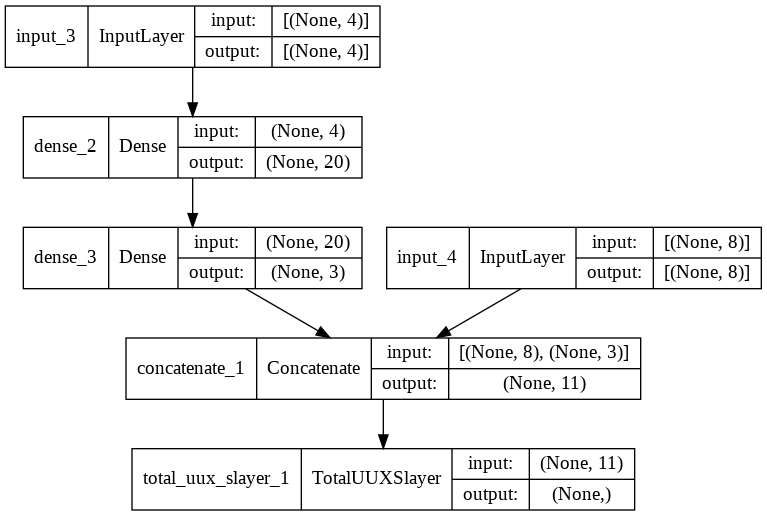

In [38]:
tf.keras.utils.plot_model(globalModel, "cffs.png", show_shapes=True)

In [55]:
#Define custom loss function to use here...
def custom_loss(y_true, y_pred):
  loss = K.square(y_true - y_pred)
  loss = K.sum(loss)
  return loss


globalModel.compile(
    #Parameters: Optimizer, Learning_rate, (loss function), epochs,
    #Adjust the learning rate here
    #optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
    optimizer = tf.keras.optimizers.Adam(.0001),
    #loss = tf.keras.losses.MeanSquaredError(),
    loss = custom_loss
)

In [44]:
Wsave = globalModel.get_weights()

## Produce CFFdists

In [56]:
def produceCFFs(numReplicas, data, Wsave):
    '''
    :param numSamples: number of replicas to produce
    :param data: whole DvcsData
    :param Wsave: saved weights
    
    :returns: numpy array of shape (numSets, numReplicas, 3)
    '''

    by_sample = []

    for i in tqdm(range(max(data.df['#Set'])+1)):

        globalModel.set_weights(Wsave) # reset weights to original value

        setI = data.getSet(i) #DvcsData object containing specific set

        by_set = []

        for sample in range(numReplicas):
            
            #this callback enables us to roll the network back to its minimum loss during training
            chkpt_path = 'networks/best-' + str(sample) + '.hdf5'
            model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=chkpt_path,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)


            globalModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(), # the sample Y will generate Fs
                        epochs=2500, verbose=0,
                        callbacks=[model_checkpoint_callback])

            globalModel.load_weights(chkpt_path) # load back minimum loss epoch

            cffs = uts.cffs_from_globalModel(globalModel, setI.Kinematics) # get cffs from middle model

            by_set.append(cffs)

        by_sample.append(by_set)
        
    return np.array(by_sample)

This took about 2 hours to run

In [ ]:
results = produceCFFs(30, data, Wsave)

  0%|          | 0/15 [00:00<?, ?it/s]

# ReH

In [ ]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 0)

Mean percent error:  880.3286730485878
RMSE:  4.7744629707640796
RMSE w yhat=mean:  2.5254628436780107
R-squared:  -2.574103233103171


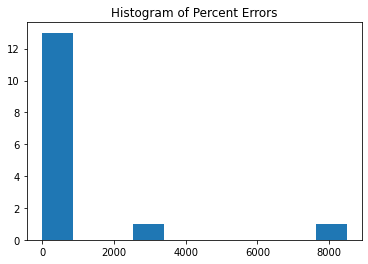

In [ ]:
uts.evaluate(y_yhat)

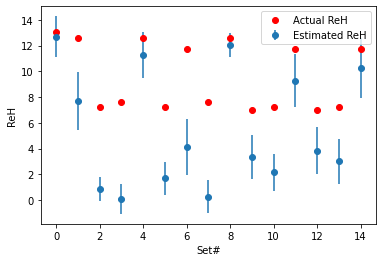

In [ ]:
uts.plotError(y_yhat, err, "ReH")

# ReE

In [ ]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 1)

Mean percent error:  164.76485695029533
RMSE:  26.422161861907448
RMSE w yhat=mean:  2.525480507907797
R-squared:  -108.45828911488752


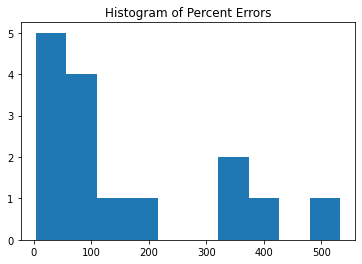

In [ ]:
uts.evaluate(y_yhat)

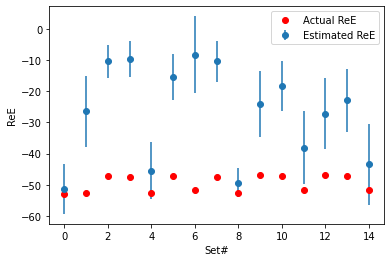

In [ ]:
uts.plotError(y_yhat, err, "ReE")

# ReHtilde

Mean percent error:  80.53379080232187
RMSE:  2.16217607694087
RMSE w yhat=mean:  1.4030345621243816
R-squared:  -1.3749002691478847


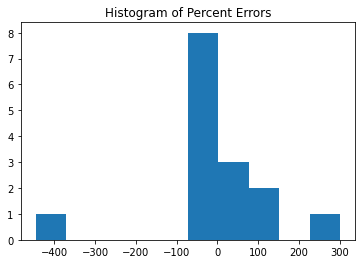

In [ ]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 2)
uts.evaluate(y_yhat)

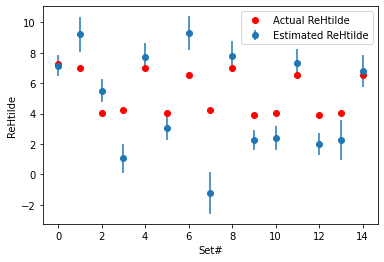

In [ ]:
uts.plotError(y_yhat, err, "ReHtilde")

# Propagated Fs at 180

Mean percent error:  7.910838994066499
RMSE:  0.0027350948061290927
RMSE w yhat=mean:  0.015855649879790133
R-squared:  0.9702438544015877


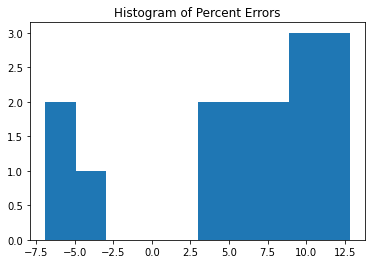

In [ ]:
y_yhat, err = uts.y_yhat_errFs(results, data)
uts.evaluate(y_yhat)

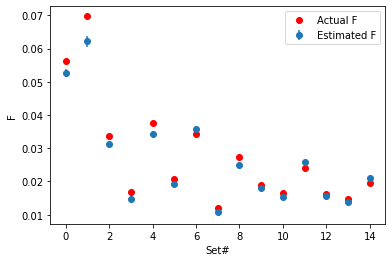

In [ ]:
uts.plotError(y_yhat, err, "F")